In [1]:
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

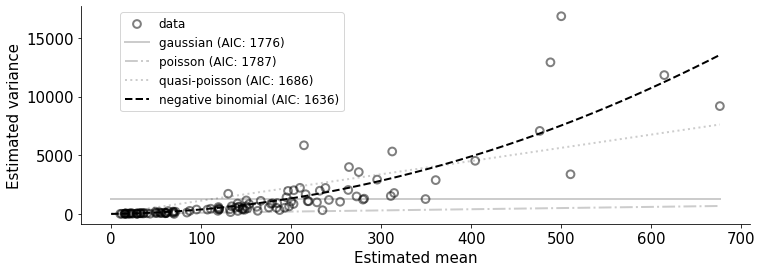


--------------------------------------------------------------------------------------
PERFORMING CALIBRATION OF INFECTIVITY, COMPLIANCE, CONTACT EFFECTIVITY AND SEASONALITY
--------------------------------------------------------------------------------------

Using data from 2020-03-15 until 2021-10-01


1) Particle swarm optimization

Using 18 cores for a population of 90, for maximally 10 iterations.

[0.42, 0.42, 0.55, 1.35, 1.7, 0.18]


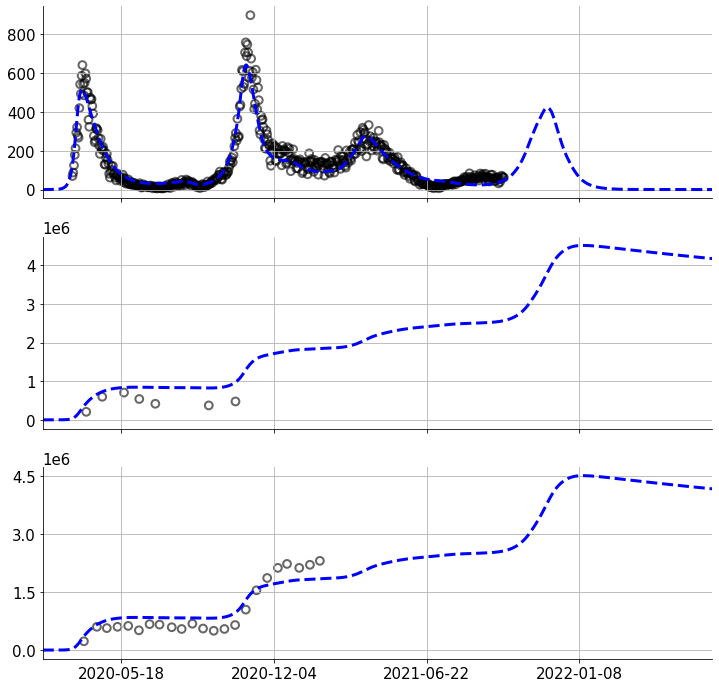

Do you want to make manual tweaks to the calibration result? [y/N]: N


In [6]:
"""
This script contains a calibration of national COVID-19 SEIQRD model to hospitalization data in Belgium.
"""

__author__      = "Tijs Alleman"
__copyright__   = "Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved."

############################
## Load required packages ##
############################

import os
import sys
import ast
import click
import json
import pickle
import emcee
import datetime
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from covid19model.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
from covid19model.data import sciensano
from covid19model.optimization.pso import *
from covid19model.optimization.nelder_mead import nelder_mead
from covid19model.optimization.objective_fcns import log_prior_uniform, ll_poisson, ll_negative_binomial, log_posterior_probability
from covid19model.optimization.utils import perturbate_PSO, run_MCMC, assign_PSO
from covid19model.visualization.optimization import plot_PSO

#############################
## Handle script arguments ##
#############################

identifier = 'tryout_automatic_alignment'
n_pso = 10
n_mcmc = 10
n_age_groups = 10
age_stratification_size=n_age_groups
start_calibration = pd.to_datetime('2020-03-15')
end_calibration = pd.to_datetime('2021-10-01')
high_performance_computing=True
backend=False
run_date = str(datetime.date.today())

##############################
## Define results locations ##
##############################

# Path where traceplot and autocorrelation figures should be stored.
# This directory is split up further into autocorrelation, traceplots
fig_path = f'../../results/calibrations/COVID19_SEIQRD/national/'
# Path where MCMC samples should be saved
samples_path = f'../../data/interim/model_parameters/COVID19_SEIQRD/calibrations/national/'
# Path where samples backend should be stored
backend_folder = f'../../results/calibrations/COVID19_SEIQRD/national/national/'
# Verify that the paths exist and if not, generate them
for directory in [fig_path, samples_path, backend_folder]:
    if not os.path.exists(directory):
        os.makedirs(directory)
# Verify that the fig_path subdirectories used in the code exist
for directory in [fig_path+"autocorrelation/", fig_path+"traceplots/", fig_path+"pso/"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

##################################################
## Load data not needed to initialize the model ##
##################################################

# Sciensano hospital and vaccination data
df_hosp, df_mort, df_cases, df_vacc = sciensano.get_sciensano_COVID19_data(update=False)
df_hosp = df_hosp.groupby(by=['date']).sum()
# Serological data
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size, update_data=False)

#from covid19model.data import model_parameters
#age_classes=pd.IntervalIndex.from_tuples([(0, 12), (12, 18), (18, 25), (25, 35), (35, 45), (45, 55), (55, 65), (65, 75), (75, 85), (85, 120)], closed='left')
#Nc_dict, params, samples_dict, initN = model_parameters.get_COVID19_SEIQRD_parameters(age_classes=age_classes)

#def compute_RO_COVID19_SEIQRD(beta, a, da, omega, Nc, initN):
#    R0_i = beta*(a*da+omega)*np.sum(Nc,axis=1)
#    return sum((R0_i*initN)/sum(initN))

#print(compute_RO_COVID19_SEIQRD(0.027, model.parameters['a'], model.parameters['da'], model.parameters['omega'], Nc_dict['total'], initN))

model.parameters['beta'] = 0.027 # R0 = 3.31 --> https://pubmed.ncbi.nlm.nih.gov/32498136/
warmup = 39 # Start 5 Feb. 2020: day of first detected COVID-19 infectee in Belgium

if __name__ == '__main__':

    #############################################################
    ## Compute the overdispersion parameters for our H_in data ##
    #############################################################

    from covid19model.optimization.utils import variance_analysis
    results, ax = variance_analysis(df_hosp['H_in'], resample_frequency='W')
    dispersion = results.loc['negative binomial', 'theta']
    plt.show()
    plt.close()

    ##########################
    ## Calibration settings ##
    ##########################

    # PSO settings
    processes = int(os.getenv('SLURM_CPUS_ON_NODE', mp.cpu_count()/2))
    multiplier_pso = 5
    maxiter = n_pso
    popsize = multiplier_pso*processes
    # MCMC settings
    multiplier_mcmc = 20
    max_n = n_mcmc
    print_n = 20
    # Define dataset
    data=[df_hosp['H_in'][start_calibration:end_calibration], df_sero_herzog['abs','mean'], df_sero_sciensano['abs','mean'][:23]]
    states = ["H_in", "R", "R"]
    weights = np.array([1, 1, 1]) # Scores of individual contributions: Dataset: 0, total ll: -4590, Dataset: 1, total ll: -4694, Dataset: 2, total ll: -4984
    log_likelihood_fnc = [ll_negative_binomial, ll_negative_binomial, ll_negative_binomial]
    log_likelihood_fnc_args = [dispersion, dispersion, dispersion]

    print('\n--------------------------------------------------------------------------------------')
    print('PERFORMING CALIBRATION OF INFECTIVITY, COMPLIANCE, CONTACT EFFECTIVITY AND SEASONALITY')
    print('--------------------------------------------------------------------------------------\n')
    print('Using data from '+start_calibration.strftime("%Y-%m-%d")+' until '+end_calibration.strftime("%Y-%m-%d")+'\n')
    print('\n1) Particle swarm optimization\n')
    print(f'Using {str(processes)} cores for a population of {popsize}, for maximally {maxiter} iterations.\n')
    sys.stdout.flush()

    #############################
    ## Global PSO optimization ##
    #############################

    # transmission
    #pars1 = ['beta',]
    #bounds1=((0.001,0.080),)
    # Effectivity parameters
    pars2 = ['eff_work', 'eff_rest', 'mentality']
    bounds2=((0,2),(0,2),(0,1))
    # Variants
    pars3 = ['K_inf',]
    # Must supply the bounds
    bounds3 = ((1.15,1.50),(1.45,2.4))
    # Seasonality
    pars4 = ['amplitude',]
    bounds4 = ((0,0.50),)
    # Join them together
    pars = pars2 + pars3 + pars4
    bounds =  bounds2 + bounds3 + bounds4
    # run optimizat
    #theta = fit_pso(model, data, pars, states, bounds, weights, maxiter=maxiter, popsize=popsize,
    #                    start_date=start_calibration, warmup=warmup, processes=processes)

    theta = [0.42, 0.42, 0.55, 1.35, 1.7, 0.18]

    ####################################
    ## Local Nelder-mead optimization ##
    ####################################

    # Define objective function
    objective_function = log_posterior_probability([],[],model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,-weights)
    # Run Nelder Mead optimization
    step = len(bounds)*[0.10,]
    #sol = nelder_mead(objective_function, np.array(theta), step, (), processes=processes)

    ###################
    ## Visualize fit ##
    ###################

    if high_performance_computing:
        
        print(theta)
        # Assign estimate
        model.parameters = assign_PSO(model.parameters, pars, theta)
        # Perform simulation
        end_visualization = '2022-07-01'
        out = model.sim(end_visualization,start_date=start_calibration, warmup=warmup)
        # Visualize fit
        ax = plot_PSO(out, data, states, start_calibration-pd.Timedelta(days=warmup), end_visualization)
        plt.show()
        plt.close()

        ####################################
        ## Ask the user for manual tweaks ##
        ####################################

        satisfied = not click.confirm('Do you want to make manual tweaks to the calibration result?', default=False)
        while not satisfied:
            # Prompt for input
            new_values = ast.literal_eval(input("Define the changes you'd like to make: "))
            # Modify theta
            for val in new_values:
                theta[val[0]] = float(val[1])
            print(theta)
            # Visualize new fit
            # Assign estimate
            pars_PSO = assign_PSO(model.parameters, pars, theta)
            model.parameters = pars_PSO
            # Perform simulation
            out = model.sim(end_visualization,start_date=start_calibration, warmup=warmup)
            # Visualize fit
            ax = plot_PSO(out, data, states, start_calibration-pd.Timedelta(days=warmup), end_visualization)
            plt.show()
            plt.close()
            # Satisfied?
            satisfied = not click.confirm('Would you like to make further changes?', default=False)

In [11]:
if __name__ == '__main__':
    
    ########################
    ## Setup MCMC sampler ##
    ########################

    print('\n2) Markov Chain Monte Carlo sampling\n')

    # Setup prior functions and arguments
    log_prior_fnc = len(bounds)*[log_prior_uniform,]
    log_prior_fnc_args = bounds
    # Perturbate PSO Estimate
    # pars1 = ['beta',]
    #pert1 = [0.01,]
    # pars2 = ['eff_schools', 'eff_work', 'eff_rest', 'mentality', 'eff_home']
    pert2 = [0.10, 0.10, 0.10]
    # pars3 = ['K_inf_abc','K_inf_delta']
    pert3 = [0.05, 0.05]
    # pars4 = ['amplitude']
    pert4 = [0.10,] 
    # Add them together and perturbate
    pert =  pert2 + pert3 + pert4 #+ pert5
    ndim, nwalkers, pos = perturbate_PSO(theta, pert, multiplier=multiplier_mcmc, bounds=log_prior_fnc_args, verbose=False)
    # Labels for traceplots
    labels = ['$\Omega_{work}$', '$\Omega_{rest}$', 'M', '$K_{inf, abc}$', '$K_{inf, delta}$', 'A']
    pars_postprocessing = ['eff_work', 'eff_rest', 'mentality', 'K_inf_abc', 'K_inf_delta', 'amplitude']
    # Set up the sampler backend if needed
    if backend:
        filename = identifier+run_date
        backend = emcee.backends.HDFBackend(backend_folder+filename)
        backend.reset(nwalkers, ndim)
    # initialize objective function
    objective_function = log_posterior_probability(log_prior_fnc,log_prior_fnc_args,model,pars,data,states,log_likelihood_fnc,log_likelihood_fnc_args,weights)


2) Markov Chain Monte Carlo sampling

